In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
import time

CPU times: total: 5.62 s
Wall time: 29.6 s


In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
X = df.drop('target', axis=1)
y = df['target']

In [4]:
std = StandardScaler()
X_std = std.fit_transform(X)

In [5]:
#Splitting into training (70%) and test sets (30%).
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42)

# **Genetic Algorithm**

In [6]:
# Initialize the Genetic Algorithm optimizer
class GeneticAlgorithm:
    def __init__(self, X_train, y_train, n_population=50, n_generations=100, 
                 mutation_rate=0.1, crossover_rate=0.8, lambda_term=0.01, penalty='no'):
        self.X_train = X_train
        self.y_train = y_train
        self.n_population = n_population
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.lambda_term = lambda_term
        self.penalty = penalty

    #--------------------------------------------------------------------------------------
    #Initialize the population with random weights between -1 and 1
    #--------------------------------------------------------------------------------------

    def initialize_population(self):
        # Initialize the population with random weights between -1 and 1
        return np.random.uniform(-1, 1, (self.n_population, self.X_train.shape[1]))
    
    #--------------------------------------------------------------------------------------
    #Fitness function to evaluate the performance of each individual in the population
    #--------------------------------------------------------------------------------------

    def fitness_function(self, beta):
        
        # Compute the logistic function
        z = np.dot(self.X_train, beta)
        p = 1 / (1 + np.exp(-z))
        epsilon = 1e-15  # To avoid log(0)
        # Compute cross entropy loss
        loss = -np.mean(self.y_train * np.log(p + epsilon) + (1 - self.y_train) * np.log(1 - p + epsilon))
        
        # Add regularization penalty if specified
        if self.penalty.lower() == 'l1':
            reg = self.lambda_term * np.sum(np.abs(beta))
        elif self.penalty.lower() == 'l2':
            reg = self.lambda_term * np.sum(beta ** 2)
        else:
            reg = 0
        # Return the negative loss (because we want to maximize fitness)
        return (loss + reg)

    #--------------------------------------------------------------------------------------
    # Select the top half individuals with the highest fitness scores
    #--------------------------------------------------------------------------------------
        
    def selection(self, population, fitness_scores):
        # Select the top half individuals with the highest fitness scores
        selected_indices = np.argsort(fitness_scores)[-int(len(population) / 2):] #Considering top half individuals
        # Select individuals based on their fitness scores
        return population[selected_indices]
    
    #--------------------------------------------------------------------------------------
    # Perform one-point crossover between two parents to create two children
    #--------------------------------------------------------------------------------------

    def crossover(self, parent1, parent2):
        # With a certain probability, perform one-point crossover
        if np.random.rand() < self.crossover_rate:
            # Ensure there's at least one valid crossover point
            if len(parent1) < 2:
                return parent1.copy(), parent2.copy()
            point = np.random.randint(1, len(parent1) - 1)
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()
    
    #--------------------------------------------------------------------------------------
    # Mutate an individual by adding a small random value to each gene with a certain probability. 
    # This function creates a mutated copy of the individual
    #--------------------------------------------------------------------------------------
    
    def mutation(self, individual):
        # Create a mutated copy of the individual
        mutated = individual.copy()
        for i in range(len(mutated)):
            if np.random.rand() < self.mutation_rate:
                mutated[i] += np.random.uniform(-0.1, 0.1)
        return mutated
    
    #--------------------------------------------------------------------------------------
    # Main optimization function that runs the genetic algorithm
    #--------------------------------------------------------------------------------------

    def optimize(self):
        population = self.initialize_population()                                                           #1. Initialize the population
        best_fitness_over_gens = []

        for generation in range(self.n_generations):
            # Compute fitness scores for the current population
            fitness_scores = np.array([self.fitness_function(ind) for ind in population])                   #2. Compute fitness scores
            best_fitness_over_gens.append(np.max(fitness_scores))                                           #3. Store the best fitness score of the generation  

            # Select the best individuals
            selected_population = self.selection(population, fitness_scores)                                #4. Select the best individuals

            new_population = []                                                                             # Stores the new population after cross over & mutation

            # Generate new population using crossover and mutation
            
            while len(new_population) < self.n_population:
                # Randomly select two parents from the selected population
                parents = selected_population[np.random.choice(len(selected_population), 2, replace=False)]
                parent1, parent2 = parents[0], parents[1]                                                   #5. Select two parents
                
                # Perform crossover and mutation to create new individuals          
                child1, child2 = self.crossover(parent1, parent2)
                new_population.append(self.mutation(child1))                                                #6. Create new individuals
                
                # Ensure the new population does not exceed the specified size
                if len(new_population) < self.n_population:
                    new_population.append(self.mutation(child2))                                            #7. Mutation of the second child
            
            population = np.array(new_population)

        #---------------------------------------------------------------------------------------
        # Recompute fitness for the final generation
        #---------------------------------------------------------------------------------------
        final_fitness_scores = np.array([self.fitness_function(ind) for ind in population])                 #8. Compute fitness scores for the final generation
        best_index = np.argmax(final_fitness_scores)                                                        #9. Get the index of the best individual    
        best_individual = population[best_index]                                                            #10. Get the best individual   
        self.best_individual = best_individual
        
        print(f"Best Individual:\n {best_individual}")
        print(f"\nBest Fitness: {final_fitness_scores[best_index]}\n")
        
        return best_individual, best_fitness_over_gens
    
    #--------------------------------------------------------------------------------------
    # Predict the target variable for the test set using the best individual
    #--------------------------------------------------------------------------------------

    def predict(self, X_test):
        z = np.dot(X_test, self.best_individual)
        p = 1 / (1 + np.exp(-z))
        y_pred =  (p > 0.5).astype(int)
        return y_pred
    
    #--------------------------------------------------------------------------------------
    # Evaluate the model using various metrics
    #--------------------------------------------------------------------------------------

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        print(f"\nEvaluation Metrics with respect to {self.penalty} penalty:\n")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}\n\n")

    #--------------------------------------------------------------------------------------
    # Plot the fitness over generations
    #--------------------------------------------------------------------------------------

    def plot_fitness(self, best_fitness):
        plt.figure(figsize=(6, 4))
        plt.plot(best_fitness)
        plt.title(f"Best Fitness Over Generations for {self.penalty} penalty")
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()


**NO PENALTY**

Best Individual:
 [ 1.34684965  1.31146071  1.0573919   1.22819798  1.13196738  1.34571096
  1.55045032  1.04198292  0.95443233  0.49160695  1.19784684  1.01542406
  1.46412028  1.62230183  0.23030039  0.6129304   1.13793646  1.65810711
 -0.11908193  0.1587587   0.96523545  0.81677094  1.0056311   1.37493972
  1.05682996  1.64679181  0.56961221  1.61886469  0.11608676  1.05584639]

Best Fitness: 15.38288890368453


Evaluation Metrics with respect to no penalty:

Accuracy: 0.0760
F1 Score: 0.0920
Precision: 0.1212
Recall: 0.0741
ROC AUC: 0.0767




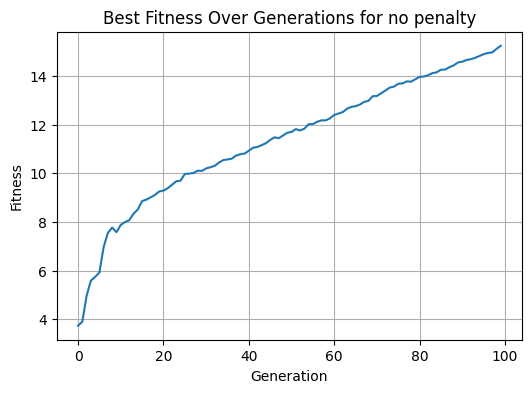

In [7]:
ga = GeneticAlgorithm(X_train, y_train, n_population=50, n_generations=100,mutation_rate=0.1, crossover_rate=0.8, lambda_term=0.01, penalty='no')
best_individual, best_fitness = ga.optimize()
ga.predict(X_test)
ga.evaluate(X_test, y_test)
ga.plot_fitness(best_fitness)

**REGULARIZATION**

Best Individual:
 [0.89077856 1.85233082 1.63834758 1.30699094 0.45978725 0.97418691
 1.31852287 1.7077225  0.49764315 0.92007195 0.98563395 0.56048148
 0.7478717  1.43004515 0.29459194 1.4017229  1.54779346 0.96840887
 0.32226229 1.00412583 0.75503433 0.79420612 1.51856608 1.15559909
 0.80155364 1.43682672 1.18314151 1.84708641 1.02458517 0.2082515 ]

Best Fitness: 15.909390890719688


Evaluation Metrics with respect to L1 penalty:

Accuracy: 0.0819
F1 Score: 0.1029
Precision: 0.1343
Recall: 0.0833
ROC AUC: 0.0813




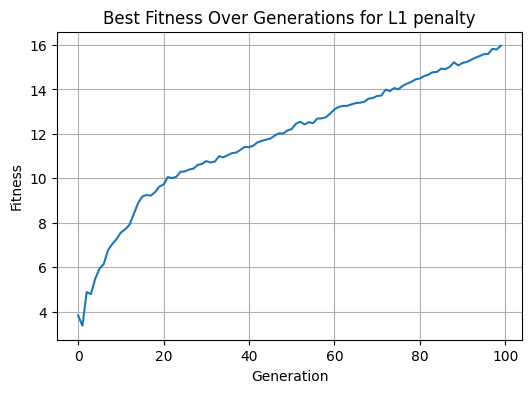

In [8]:
ga = GeneticAlgorithm(X_train, y_train, n_population=50, n_generations=100,mutation_rate=0.1, crossover_rate=0.8, lambda_term=0.01, penalty='L1')
best_individual, best_fitness = ga.optimize()
ga.predict(X_test)
ga.evaluate(X_test, y_test)
ga.plot_fitness(best_fitness)


Best Individual:
 [ 1.56940426  0.94084726  1.5812773   1.43029255  1.54560686  1.37362502
  1.58925538  1.3501601   1.00407449 -0.82631927  1.07762091 -0.1268882
  1.11099956  1.01073636 -0.71637438  0.5024215  -0.36102558  1.46230747
 -0.80679399  0.90922375  1.49715847  1.36559756  1.59894205  1.2474195
  0.93603378  1.46272664  1.22502282  0.91964286  0.4998085   0.91699711]

Best Fitness: 16.308055836711652


Evaluation Metrics with respect to L2 penalty:

Accuracy: 0.0585
F1 Score: 0.0800
Precision: 0.1045
Recall: 0.0648
ROC AUC: 0.0562




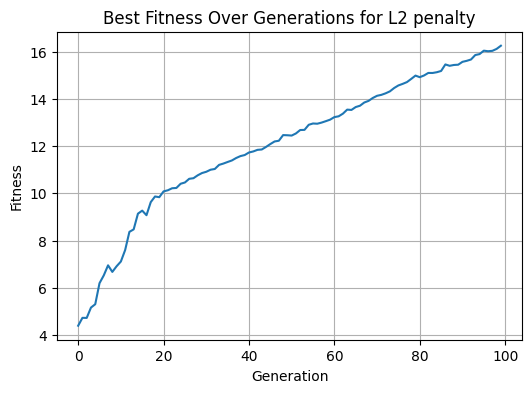

In [9]:
ga = GeneticAlgorithm(X_train, y_train, n_population=50, n_generations=100,mutation_rate=0.1, crossover_rate=0.8, lambda_term=0.01, penalty='L2')
best_individual, best_fitness = ga.optimize()
ga.predict(X_test)
ga.evaluate(X_test, y_test)
ga.plot_fitness(best_fitness)


**HYPERPARAMETER TUNING**

Best Individual:
 [ 1.96210095  0.89885584  1.00026136  0.87798714  1.20442436  0.06841714
  2.23744097  2.1623465   1.69692581  0.96909782  1.18463397 -0.44735815
  0.8599965   1.52703367  0.81535802  1.02324997  0.36828011  1.64796243
  0.34426667  0.98981375  1.1778679  -0.10493565  1.88264815  1.23817077
  1.18821765  1.58501442  0.88774158  2.35176714  1.08639048  1.26402063]

Best Fitness: 17.463963983042095


Evaluation Metrics with respect to L1 penalty:

Accuracy: 0.0877
F1 Score: 0.1034
Precision: 0.1364
Recall: 0.0833
ROC AUC: 0.0893




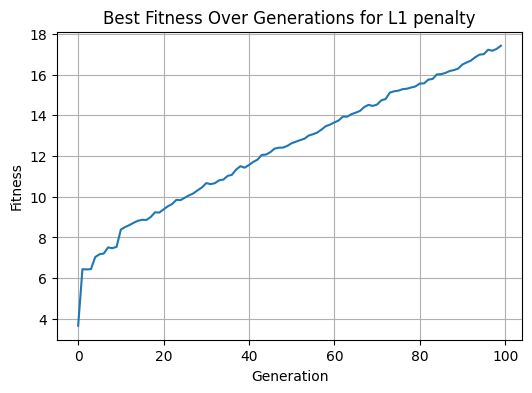

In [10]:
ga = GeneticAlgorithm(X_train, y_train, n_population=50, n_generations=100,mutation_rate=0.15, crossover_rate=0.9, lambda_term=0.01, penalty='L1')
best_individual, best_fitness = ga.optimize()
ga.predict(X_test)
ga.evaluate(X_test, y_test)
ga.plot_fitness(best_fitness)


Best Individual:
 [ 1.38899639  0.95017636  1.60122523  1.19675182  1.41830373  1.63137381
  1.23728014  1.9128829   0.4488932  -0.4010821   0.89796282  0.09707544
  1.21981169  1.46034126 -0.96407578  0.98552066  0.77046419  1.23823803
  0.01347063  0.18845988  1.67029419  1.28680625  1.58263497  1.9793802
  1.77905829  1.59491982  1.31149263  1.92138084  1.27665286 -0.23568077]

Best Fitness: 18.117937117981405


Evaluation Metrics with respect to L2 penalty:

Accuracy: 0.0643
F1 Score: 0.0698
Precision: 0.0938
Recall: 0.0556
ROC AUC: 0.0675




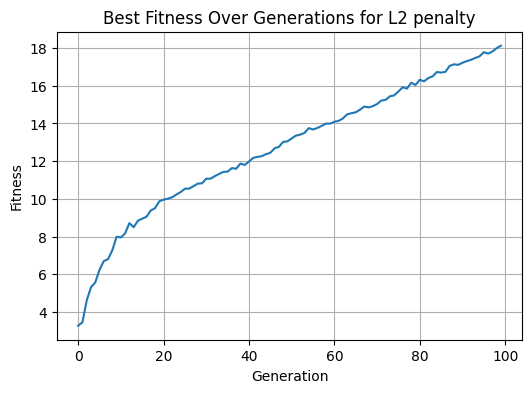

In [11]:
ga = GeneticAlgorithm(X_train, y_train, n_population=50, n_generations=100,mutation_rate=0.15, crossover_rate=0.9, lambda_term=0.01, penalty='L2')
best_individual, best_fitness = ga.optimize()
ga.predict(X_test)
ga.evaluate(X_test, y_test)
ga.plot_fitness(best_fitness)
